In [2]:
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import (
    TrOCRProcessor,
    VisionEncoderDecoderModel,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
)
from datasets import Dataset, DatasetDict
import matplotlib.pyplot as plt
import numpy as np
import os

/Users/martinqian/.pyenv/versions/3.12.7/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import requests

# load image from the IAM database (actually this model is meant to be used on printed text)
url = "https://fki.tic.heia-fr.ch/static/img/a01-122-02-00.jpg"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-printed")
pixel_values = processor(images=image, return_tensors="pt").pixel_values

generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.48.0"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder


# Jupyter Notebook Conversion
# Step 1: Data Preparation

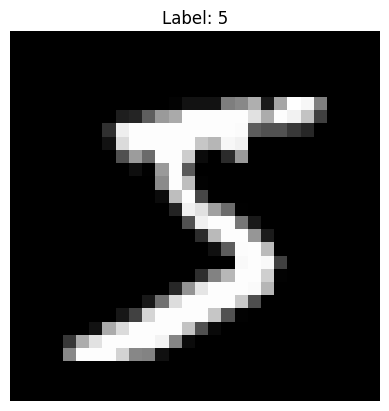

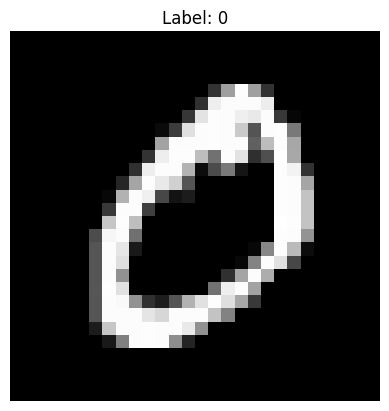

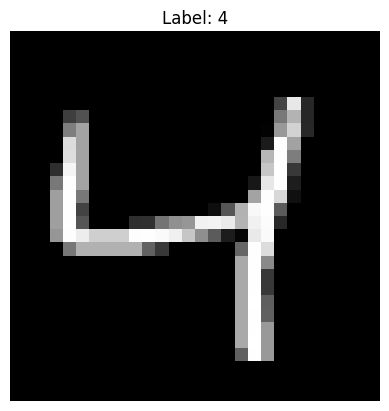

In [3]:
transform = transforms.Compose(
    [transforms.Grayscale(num_output_channels=3), transforms.ToTensor()]
)
train_data = datasets.MNIST(
    root="../../data/", train=True, download=True, transform=transform
)


def visualize_sample(dataset, index):
    """Visualize a single sample from the dataset."""
    image, label = dataset[index]
    plt.imshow(image[0], cmap="gray")
    plt.title(f"Label: {label}")
    plt.axis("off")
    plt.show()


# Visualize a few samples
for i in range(3):
    visualize_sample(train_data, i)

In [4]:
# Prepare the dataset for Hugging Face's Dataset API
dataset_dict = {
    "image": [train_data[i][0].numpy() for i in range(len(train_data))],
    "label": [int(train_data[i][1]) for i in range(len(train_data))],
}
dataset = Dataset.from_dict(dataset_dict)

# Split dataset into train and test
dataset = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = dataset["train"]
test_dataset = dataset["test"]

# Step 2: Initialize the Processor and Model

In [5]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten").to("mps")

# Adjust model config for MNIST
model.config.decoder.vocab_size = 11  # 10 digits + <eos> token
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.eos_token_id = processor.tokenizer.eos_token_id
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.max_length = 5  # Ensure the decoder output has a fixed sequence length


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.48.0"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared deco


# Step 3: Define Training Arguments

In [6]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./trained_model/",
    eval_strategy="steps",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    num_train_epochs=5,
    save_steps=500,
    save_total_limit=2,
    predict_with_generate=True,
    logging_dir="logs",
    logging_steps=10,
)

In [7]:
print(model.device)

mps:0


In [12]:
import gc
gc.collect()


def preprocess_data(example):
    pixel_values = processor(
        images=torch.tensor(example["image"], dtype=torch.float32).to("mps"),
        return_tensors="pt",
        do_rescale=False,
    ).pixel_values.squeeze(
        0
    )  # Remove batch dimension

    label = torch.tensor(example["label"], dtype=torch.long).to("mps")

    # Debugging
    torch.mps.synchronize()  # Ensure all GPU operations are complete
    print("Pixel values (type):", type(pixel_values))
    print(
        "Pixel values (shape):", pixel_values.cpu().shape
    )  # Move to CPU for inspection
    print("Label (type):", type(label))
    print("Label (value):", label.cpu().item())  # Move to CPU for inspection

    return {
        "pixel_values": pixel_values,
        "label": label,
    }


# Apply preprocessing with memory efficiency
train_dataset_small = train_dataset.select(range(100))
test_dataset_small = test_dataset.select(range(100))


# train_dataset = train_dataset.map(preprocess_data)
# test_dataset = test_dataset.map(preprocess_data)

train_dataset_small = train_dataset_small.map(preprocess_data)
test_dataset_small = test_dataset_small.map(preprocess_data)


Map:  46%|████▌     | 46/100 [00:00<00:00, 222.49 examples/s]

Pixel values (type): <class 'torch.Tensor'>
Pixel values (shape): torch.Size([3, 384, 384])
Label (type): <class 'torch.Tensor'>
Label (value): 7
Pixel values (type): <class 'torch.Tensor'>
Pixel values (shape): torch.Size([3, 384, 384])
Label (type): <class 'torch.Tensor'>
Label (value): 3
Pixel values (type): <class 'torch.Tensor'>
Pixel values (shape): torch.Size([3, 384, 384])
Label (type): <class 'torch.Tensor'>
Label (value): 5
Pixel values (type): <class 'torch.Tensor'>
Pixel values (shape): torch.Size([3, 384, 384])
Label (type): <class 'torch.Tensor'>
Label (value): 2
Pixel values (type): <class 'torch.Tensor'>
Pixel values (shape): torch.Size([3, 384, 384])
Label (type): <class 'torch.Tensor'>
Label (value): 2
Pixel values (type): <class 'torch.Tensor'>
Pixel values (shape): torch.Size([3, 384, 384])
Label (type): <class 'torch.Tensor'>
Label (value): 5
Pixel values (type): <class 'torch.Tensor'>
Pixel values (shape): torch.Size([3, 384, 384])
Label (type): <class 'torch.Tens

Map:  69%|██████▉   | 69/100 [00:00<00:00, 223.33 examples/s]

Pixel values (type): <class 'torch.Tensor'>
Pixel values (shape): torch.Size([3, 384, 384])
Label (type): <class 'torch.Tensor'>
Label (value): 3
Pixel values (type): <class 'torch.Tensor'>
Pixel values (shape): torch.Size([3, 384, 384])
Label (type): <class 'torch.Tensor'>
Label (value): 3
Pixel values (type): <class 'torch.Tensor'>
Pixel values (shape): torch.Size([3, 384, 384])
Label (type): <class 'torch.Tensor'>
Label (value): 9
Pixel values (type): <class 'torch.Tensor'>
Pixel values (shape): torch.Size([3, 384, 384])
Label (type): <class 'torch.Tensor'>
Label (value): 2
Pixel values (type): <class 'torch.Tensor'>
Pixel values (shape): torch.Size([3, 384, 384])
Label (type): <class 'torch.Tensor'>
Label (value): 7
Pixel values (type): <class 'torch.Tensor'>
Pixel values (shape): torch.Size([3, 384, 384])
Label (type): <class 'torch.Tensor'>
Label (value): 8
Pixel values (type): <class 'torch.Tensor'>
Pixel values (shape): torch.Size([3, 384, 384])
Label (type): <class 'torch.Tens

Map:  94%|█████████▍| 94/100 [00:00<00:00, 228.94 examples/s]

Pixel values (type): <class 'torch.Tensor'>
Pixel values (shape): torch.Size([3, 384, 384])
Label (type): <class 'torch.Tensor'>
Label (value): 2
Pixel values (type): <class 'torch.Tensor'>
Pixel values (shape): torch.Size([3, 384, 384])
Label (type): <class 'torch.Tensor'>
Label (value): 5
Pixel values (type): <class 'torch.Tensor'>
Pixel values (shape): torch.Size([3, 384, 384])
Label (type): <class 'torch.Tensor'>
Label (value): 5
Pixel values (type): <class 'torch.Tensor'>
Pixel values (shape): torch.Size([3, 384, 384])
Label (type): <class 'torch.Tensor'>
Label (value): 8
Pixel values (type): <class 'torch.Tensor'>
Pixel values (shape): torch.Size([3, 384, 384])
Label (type): <class 'torch.Tensor'>
Label (value): 6
Pixel values (type): <class 'torch.Tensor'>
Pixel values (shape): torch.Size([3, 384, 384])
Label (type): <class 'torch.Tensor'>
Label (value): 7
Pixel values (type): <class 'torch.Tensor'>
Pixel values (shape): torch.Size([3, 384, 384])
Label (type): <class 'torch.Tens

Map:  22%|██▏       | 22/100 [00:00<00:00, 214.70 examples/s]

Pixel values (type): <class 'torch.Tensor'>
Pixel values (shape): torch.Size([3, 384, 384])
Label (type): <class 'torch.Tensor'>
Label (value): 8
Pixel values (type): <class 'torch.Tensor'>
Pixel values (shape): torch.Size([3, 384, 384])
Label (type): <class 'torch.Tensor'>
Label (value): 7
Pixel values (type): <class 'torch.Tensor'>
Pixel values (shape): torch.Size([3, 384, 384])
Label (type): <class 'torch.Tensor'>
Label (value): 1
Pixel values (type): <class 'torch.Tensor'>
Pixel values (shape): torch.Size([3, 384, 384])
Label (type): <class 'torch.Tensor'>
Label (value): 6
Pixel values (type): <class 'torch.Tensor'>
Pixel values (shape): torch.Size([3, 384, 384])
Label (type): <class 'torch.Tensor'>
Label (value): 0
Pixel values (type): <class 'torch.Tensor'>
Pixel values (shape): torch.Size([3, 384, 384])
Label (type): <class 'torch.Tensor'>
Label (value): 3
Pixel values (type): <class 'torch.Tensor'>
Pixel values (shape): torch.Size([3, 384, 384])
Label (type): <class 'torch.Tens

Map:  72%|███████▏  | 72/100 [00:00<00:00, 234.27 examples/s]

Pixel values (type): <class 'torch.Tensor'>
Pixel values (shape): torch.Size([3, 384, 384])
Label (type): <class 'torch.Tensor'>
Label (value): 3
Pixel values (type): <class 'torch.Tensor'>
Pixel values (shape): torch.Size([3, 384, 384])
Label (type): <class 'torch.Tensor'>
Label (value): 8
Pixel values (type): <class 'torch.Tensor'>
Pixel values (shape): torch.Size([3, 384, 384])
Label (type): <class 'torch.Tensor'>
Label (value): 8
Pixel values (type): <class 'torch.Tensor'>
Pixel values (shape): torch.Size([3, 384, 384])
Label (type): <class 'torch.Tensor'>
Label (value): 3
Pixel values (type): <class 'torch.Tensor'>
Pixel values (shape): torch.Size([3, 384, 384])
Label (type): <class 'torch.Tensor'>
Label (value): 3
Pixel values (type): <class 'torch.Tensor'>
Pixel values (shape): torch.Size([3, 384, 384])
Label (type): <class 'torch.Tensor'>
Label (value): 6
Pixel values (type): <class 'torch.Tensor'>
Pixel values (shape): torch.Size([3, 384, 384])
Label (type): <class 'torch.Tens

Map:  98%|█████████▊| 98/100 [00:00<00:00, 239.80 examples/s]

Pixel values (type): <class 'torch.Tensor'>
Pixel values (shape): torch.Size([3, 384, 384])
Label (type): <class 'torch.Tensor'>
Label (value): 4
Pixel values (type): <class 'torch.Tensor'>
Pixel values (shape): torch.Size([3, 384, 384])
Label (type): <class 'torch.Tensor'>
Label (value): 2
Pixel values (type): <class 'torch.Tensor'>
Pixel values (shape): torch.Size([3, 384, 384])
Label (type): <class 'torch.Tensor'>
Label (value): 8
Pixel values (type): <class 'torch.Tensor'>
Pixel values (shape): torch.Size([3, 384, 384])
Label (type): <class 'torch.Tensor'>
Label (value): 4


Map: 100%|██████████| 100/100 [00:00<00:00, 114.10 examples/s]


# Step 4: Define a Data Collator

In [34]:
from typing import List, Dict


def data_collator(features: List[dict]) -> Dict[str, torch.Tensor]:
    pixel_values = []
    for idx, feature in enumerate(features):
        if isinstance(feature["pixel_values"], list):
            print(f"Feature {idx} pixel_values is a list. Converting to tensor.")
            pixel_values.append(
                torch.tensor(feature["pixel_values"], dtype=torch.float32)
            )
        else:
            pixel_values.append(feature["pixel_values"])

    # Stack pixel_values and squeeze the extra dimension if present
    pixel_values = (
        torch.stack(pixel_values).squeeze(1).to("mps")
    )  # Squeeze the singleton dimension

    # Convert labels to tensors and move to the appropriate device
    labels = torch.tensor([f["label"] for f in features], dtype=torch.long).to("mps")

    # Debugging: Confirm the shapes
    print("Pixel values shape after stacking and squeezing:", pixel_values.shape)
    print("Labels shape:", labels.shape)

    return {
        "pixel_values": pixel_values,
        "labels": labels,
    }

# Step 5: Train the Model

In [35]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
)

trainer.train()


Feature 0 pixel_values is a list. Converting to tensor.
Feature 1 pixel_values is a list. Converting to tensor.
Feature 2 pixel_values is a list. Converting to tensor.
Feature 3 pixel_values is a list. Converting to tensor.
Feature 4 pixel_values is a list. Converting to tensor.
Feature 5 pixel_values is a list. Converting to tensor.
Feature 6 pixel_values is a list. Converting to tensor.
Feature 7 pixel_values is a list. Converting to tensor.
Feature 8 pixel_values is a list. Converting to tensor.
Feature 9 pixel_values is a list. Converting to tensor.
Feature 10 pixel_values is a list. Converting to tensor.
Feature 11 pixel_values is a list. Converting to tensor.
Feature 12 pixel_values is a list. Converting to tensor.
Feature 13 pixel_values is a list. Converting to tensor.
Feature 14 pixel_values is a list. Converting to tensor.
Feature 15 pixel_values is a list. Converting to tensor.
Pixel values shape after stacking and squeezing: torch.Size([16, 3, 384, 384])
Labels shape: torch

IndexError: too many indices for tensor of dimension 1

# Step 6: Save the trained model

In [ ]:
model.save_pretrained("src/model/trained_model/")
processor.save_pretrained("src/model/trained_model/")
print(f"Model and processor saved to src/model/trained_model/")